In [1198]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [1199]:
stopwords = stopwords.words('russian')

In [1200]:
df = pd.read_csv('./data/Petitions.csv')
df

id                               public_petition_text  \
0      3168490                                     снег на дороге   
1      3219678                очистить кабельный киоск от рекламы   
2      2963920  Просим убрать все деревья и кустарники, которы...   
3      3374910  Неудовлетворительное состояние парадной - надп...   
4      3336285                                           Граффити   
...        ...                                                ...   
59884  3128111                           прошу закрасить граффити   
59885  3276713       Прошу вас отремонтировать пешеходную дорожку   
59886  3274663  Необходимо демонтировать незаконную рекламную ...   
59887  3359308  Очень гремит на ветру металлическая часть окна...   
59888  3209098  Две проблемы в одном:\n1) Незаконные надписи/о...   

                                         reason_category  
0                                        Благоустройство  
1                                        Благоустройство  
2                                        Благоустройство  
3                                         Содержание МКД  
4                                        Благоустройство  
...                                                  ...  
59884                                    Благоустройство  
59885                                    Благоустройство  
59886  Незаконная информационная и (или) рекламная ко...  
59887                                             Кровля  
59888                                    Благоустройство  

[59889 rows x 3 columns]

In [1201]:
print(len(df['reason_category'].unique()), "\n", df['reason_category'].value_counts())

15 
 reason_category
Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элементов уличной инфраструктуры                       1164
Кровля                                                                                825
Водоснабжение                                                                         809
Состояние рекламных или информационных конструкций                                    673
Санитарное состояние                                                                  434
Центральное отопление                                                          

In [1202]:
df.drop(columns="id", inplace=True)

In [1203]:
new_df = df.sample(100)
new_df

public_petition_text  \
25653  Незаконное размещение информационной и (или) р...   
12603                                     не очищен снег   
14462  Две рябина у входа в парадную 5, напротив скам...   
42791  Поврежденная водосточная труба. Фотофиксация- ...   
25830  Прошу оборудовать съезд с дорожки для обеспече...   
...                                                  ...   
31204       Два дня подряд неисправный лифт. 8 парадная.   
58226                                    Мусор на газоне   
17151  Плесень от протекающей с крыши кровли!  Неделю...   
23018  Доводчик не настроен, откручен с одной стороны...   
59624                                            Удалить   

                                         reason_category  
25653  Незаконная информационная и (или) рекламная ко...  
12603                                    Благоустройство  
14462                                    Благоустройство  
42791                                             Кровля  
25830                                    Благоустройство  
...                                                  ...  
31204                                     Содержание МКД  
58226                                    Благоустройство  
17151                                             Кровля  
23018                                     Содержание МКД  
59624                                    Благоустройство  

[100 rows x 2 columns]

In [1204]:
X = new_df["public_petition_text"].to_list()

In [1205]:
def preprocessing_text(text):
    lst = []
    #remove html
    for i in text:
        html_tag=re.compile('<.*?>')
        text_no_html = html_tag.sub('', i)
        #remove quots
        text_only_letters = re.sub('[^\w\s]', '', text_no_html)
        #tokenizим
        words = word_tokenize(text_only_letters)
        #morphим
        morph = MorphAnalyzer()
        lemmas = [morph.normal_forms(w)[0] for w in words]
        #del_sw
        prepared = [w for w in lemmas if w not in stopwords]
        lemm_sentce = ' '.join(prepared)
        lst.append(lemm_sentce)
        # lst.append(prepared)
    return lst


In [1206]:
prepro_text = preprocessing_text(text=X)
print(len(prepro_text))
prepro_text

100


['незаконный размещение информационный рекламный конструкция территория санктпетербург',
 'очистить снег',
 'рябина вход парадный 5 напротив скамья повредить корневой стволовой гниль это свидетельствовать разрастись вокруг ствол плодовый тело гриб',
 'повредить водосточный труба фотофиксация 28022021г 1425',
 'просить оборудовать съезд дорожка обеспечение доступность объект маломобильный группа население пример простой быстрый решение представить сообщение проблема 2332944 2412690 2482219 2482225',
 'лифт новый установить январь 1 этаж дверт верхний часть сходиться внизу щель 152 палец закрытый дверь 4 подъезд',
 'дверь подъезд закрываться парадный номер 2 23 дом',
 'висеть провод фасад',
 'убрать мусор пятёрочка',
 'газон бетонный мусор вывести',
 'очистить',
 'парадный 10 жилой дом адрес переулок каховский дом 7 смять водосточный труба просьба исправить',
 '45 день мусор уберать запах страшный лестница мыть',
 'испачкать стена дом газовый жёлтый труба арка вход улица малый конюшенный

In [1207]:
def del_word_len_one(list_w):
    w_del = []
    for i in range(0, len(list_w)):
        if len(list_w[i].split()) < 3:
            w_del.append(i)
    for index in sorted(w_del, reverse=True):
        del list_w[index]
        
    return list_w

In [1208]:
new_prepro_text = del_word_len_one(prepro_text)
new_prepro_text

['незаконный размещение информационный рекламный конструкция территория санктпетербург',
 'рябина вход парадный 5 напротив скамья повредить корневой стволовой гниль это свидетельствовать разрастись вокруг ствол плодовый тело гриб',
 'повредить водосточный труба фотофиксация 28022021г 1425',
 'просить оборудовать съезд дорожка обеспечение доступность объект маломобильный группа население пример простой быстрый решение представить сообщение проблема 2332944 2412690 2482219 2482225',
 'лифт новый установить январь 1 этаж дверт верхний часть сходиться внизу щель 152 палец закрытый дверь 4 подъезд',
 'дверь подъезд закрываться парадный номер 2 23 дом',
 'висеть провод фасад',
 'убрать мусор пятёрочка',
 'газон бетонный мусор вывести',
 'парадный 10 жилой дом адрес переулок каховский дом 7 смять водосточный труба просьба исправить',
 '45 день мусор уберать запах страшный лестница мыть',
 'испачкать стена дом газовый жёлтый труба арка вход улица малый конюшенный дом 10 правый сторона',
 'отсу

In [1209]:
count_vocab = set((' '.join(new_prepro_text).split()))
word_to_ix = {word: i for i, word in enumerate(count_vocab)}
word_to_ix

{'реконструкция': 0,
 'расследование': 1,
 'подобрать': 2,
 'жизнь': 3,
 'ужасный': 4,
 'отстой': 5,
 'вообще': 6,
 'молокан': 7,
 'повредить': 8,
 'боровой': 9,
 'износ': 10,
 'похожий': 11,
 'открываться': 12,
 'галочка': 13,
 'лифтовый': 14,
 'припарковать': 15,
 'работать': 16,
 'внутридворовый': 17,
 'срочно': 18,
 'бумага': 19,
 'требоваться': 20,
 'уходить': 21,
 'асфальт': 22,
 'кафебатон': 23,
 '130': 24,
 'элемент': 25,
 'заменить': 26,
 'помойка': 27,
 'тротуар': 28,
 'глубокий': 29,
 'состояние': 30,
 'электронный': 31,
 'пять': 32,
 'почему': 33,
 'часть': 34,
 'открутить': 35,
 'запах': 36,
 'несмотря': 37,
 'снежный': 38,
 'акт': 39,
 'возможность': 40,
 'комсомольский': 41,
 '15': 42,
 'иметься': 43,
 'незаконный': 44,
 'требовать': 45,
 'конструктивный': 46,
 'предназначить': 47,
 'доводчик': 48,
 'который': 49,
 'грузовой': 50,
 'замок': 51,
 'рф': 52,
 'водоём': 53,
 'тч': 54,
 'пулковский': 55,
 'морской': 56,
 '2020': 57,
 'авто': 58,
 'пролёт': 59,
 'москва': 60,


In [1210]:
def get_context_words(data, m):
    central_words = []
    context_words = []
    s = []
    for k in range(0, len(data)):
        for i in range(m, (len(data[k].split()) - (m * 2)) + (m)):
            # print(i)
            central_word = data[k].split()[i]
            central_words.append(word_to_ix[central_word])

            context_word = []
            for j in range(i - m, i + m + 1):
                if j != i:
                    context_word.append(word_to_ix[data[k].split()[j]])
            context_words.append(context_word)

    s = list(zip(central_words, context_words))

    return s

In [1211]:
s = get_context_words(new_prepro_text, m=1)

In [1212]:
s

[(378, [44, 458]),
 (458, [378, 363]),
 (363, [458, 205]),
 (205, [363, 508]),
 (508, [205, 100]),
 (146, [247, 86]),
 (86, [146, 188]),
 (188, [86, 66]),
 (66, [188, 439]),
 (439, [66, 8]),
 (8, [439, 641]),
 (641, [8, 159]),
 (159, [641, 482]),
 (482, [159, 120]),
 (120, [482, 299]),
 (299, [120, 281]),
 (281, [299, 435]),
 (435, [281, 275]),
 (275, [435, 287]),
 (287, [275, 285]),
 (285, [287, 465]),
 (324, [8, 392]),
 (392, [324, 459]),
 (459, [392, 372]),
 (372, [459, 226]),
 (81, [352, 609]),
 (609, [81, 453]),
 (453, [609, 393]),
 (393, [453, 426]),
 (426, [393, 384]),
 (384, [426, 267]),
 (267, [384, 607]),
 (607, [267, 425]),
 (425, [607, 373]),
 (373, [425, 126]),
 (126, [373, 523]),
 (523, [126, 406]),
 (406, [523, 104]),
 (104, [406, 194]),
 (194, [104, 601]),
 (601, [194, 123]),
 (123, [601, 63]),
 (63, [123, 583]),
 (583, [63, 276]),
 (512, [450, 365]),
 (365, [512, 536]),
 (536, [365, 268]),
 (268, [536, 511]),
 (511, [268, 153]),
 (153, [511, 220]),
 (220, [153, 34]),
 

In [1213]:
word_list = list(word_to_ix.keys())
word_list

['реконструкция',
 'расследование',
 'подобрать',
 'жизнь',
 'ужасный',
 'отстой',
 'вообще',
 'молокан',
 'повредить',
 'боровой',
 'износ',
 'похожий',
 'открываться',
 'галочка',
 'лифтовый',
 'припарковать',
 'работать',
 'внутридворовый',
 'срочно',
 'бумага',
 'требоваться',
 'уходить',
 'асфальт',
 'кафебатон',
 '130',
 'элемент',
 'заменить',
 'помойка',
 'тротуар',
 'глубокий',
 'состояние',
 'электронный',
 'пять',
 'почему',
 'часть',
 'открутить',
 'запах',
 'несмотря',
 'снежный',
 'акт',
 'возможность',
 'комсомольский',
 '15',
 'иметься',
 'незаконный',
 'требовать',
 'конструктивный',
 'предназначить',
 'доводчик',
 'который',
 'грузовой',
 'замок',
 'рф',
 'водоём',
 'тч',
 'пулковский',
 'морской',
 '2020',
 'авто',
 'пролёт',
 'москва',
 'здоровье',
 'спасибо',
 '2412690',
 'лампочка',
 'граффити',
 'напротив',
 'внутри',
 'кровь',
 'начальник',
 'щёлкать',
 'классификация',
 '6',
 'закрытый',
 'день',
 'мусорный',
 '170',
 'малый',
 'лампа',
 '9м',
 'окурок',
 'обор

In [1214]:
with open('word_list3.tsv', 'w', encoding='utf-8') as f:
    f.write('\n'.join(word_list))

In [1215]:
def embedding_matrix(f):
    count_vocab = set((' '.join(f).split()))
    print(len(count_vocab))
    word_to_ix = {word: i for i, word in enumerate(count_vocab)}
    print(word_to_ix)
    a = max(word_to_ix.values()) + 1
    print(a)
    matrica = [[0] * a for _ in range(a)]
    for k in range(0, len(f)):
        b = len(f[k].split())
        words = f[k].split()
        for i in range(b):
            for j in range(i+1, b):
                if words[i] in f[k] and words[j] in f[k]:
                    matrica[word_to_ix[words[i]]][word_to_ix[words[j]]] += 1
                    matrica[word_to_ix[words[j]]][word_to_ix[words[i]]] += 1

    # for row in matrica:
    #     print(row)
    
    return matrica

In [1216]:
emb_matr = embedding_matrix(new_prepro_text)
emb_matr

652
{'реконструкция': 0, 'расследование': 1, 'подобрать': 2, 'жизнь': 3, 'ужасный': 4, 'отстой': 5, 'вообще': 6, 'молокан': 7, 'повредить': 8, 'боровой': 9, 'износ': 10, 'похожий': 11, 'открываться': 12, 'галочка': 13, 'лифтовый': 14, 'припарковать': 15, 'работать': 16, 'внутридворовый': 17, 'срочно': 18, 'бумага': 19, 'требоваться': 20, 'уходить': 21, 'асфальт': 22, 'кафебатон': 23, '130': 24, 'элемент': 25, 'заменить': 26, 'помойка': 27, 'тротуар': 28, 'глубокий': 29, 'состояние': 30, 'электронный': 31, 'пять': 32, 'почему': 33, 'часть': 34, 'открутить': 35, 'запах': 36, 'несмотря': 37, 'снежный': 38, 'акт': 39, 'возможность': 40, 'комсомольский': 41, '15': 42, 'иметься': 43, 'незаконный': 44, 'требовать': 45, 'конструктивный': 46, 'предназначить': 47, 'доводчик': 48, 'который': 49, 'грузовой': 50, 'замок': 51, 'рф': 52, 'водоём': 53, 'тч': 54, 'пулковский': 55, 'морской': 56, '2020': 57, 'авто': 58, 'пролёт': 59, 'москва': 60, 'здоровье': 61, 'спасибо': 62, '2412690': 63, 'лампочка'

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [1217]:
from sklearn.decomposition import PCA

In [1218]:
pca = PCA(n_components=30)
pca.fit(emb_matr)
data_pca = pca.transform(emb_matr)

In [1219]:
np.savetxt('embeddings.tsv', data_pca, delimiter='\t')

## Neural_buri

In [1220]:
# [(256, [23, 45])
# (256, [23, 45])
# (256, [23, 45])]
X_i = np.array([])
y_i = np.array([])
for i, j in s:
    y_i = np.insert(y_i, 0, i)
    X_i = np.insert(X_i, 0, j).reshape(-1, 2)

In [1221]:
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size=0.15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((810, 2), (144, 2), (810,), (144,))

In [1222]:
batch_size = 256
train_ds = TensorDataset(torch.from_numpy(X_train).type(torch.long), torch.from_numpy(y_train).type(torch.long))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [1223]:
train_dl.batch_size

256

In [1224]:
import torch.nn.functional as F

In [1225]:
class CBOWModeler(nn.Module):  
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 250)
        self.linear2 = nn.Linear(250, vocab_size)

    def forward(self, inputs):
        #Size(256, 2, 10)
        #batch_size x context * 2 x embedding_dim
        #.mean(1) batch_size x context * 1 x embedding_dim
        embeds = (self.embeddings(inputs)).mean(1)
        out1 = F.tanh(self.linear1(embeds))
        out2 = self.linear2(out1)           
        log_probs = F.log_softmax(out2, dim=1)
        return log_probs
    

In [1226]:
loss_function = nn.NLLLoss()

In [1227]:
model = CBOWModeler(len(count_vocab), 10)
model

CBOWModeler(
  (embeddings): Embedding(652, 10)
  (linear1): Linear(in_features=10, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=652, bias=True)
)

In [1228]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [1229]:
wordvecs = model.linear2.weight.cpu().detach().numpy()
wordvecs

array([[-0.02167378,  0.02458642, -0.00921828, ..., -0.03169065,
        -0.01470226,  0.05974489],
       [-0.02267309, -0.04954096,  0.03888325, ...,  0.0087441 ,
        -0.00838188, -0.04611831],
       [ 0.04700938, -0.05515783,  0.04241876, ..., -0.04682644,
        -0.02074819,  0.00710779],
       ...,
       [ 0.0546816 ,  0.0416091 , -0.05717806, ..., -0.04768094,
        -0.0073329 ,  0.00354297],
       [ 0.02350412,  0.038041  ,  0.02980934, ...,  0.03267063,
         0.04450375,  0.01878777],
       [ 0.01535979,  0.01727717,  0.0548242 , ..., -0.04185336,
        -0.0135067 ,  0.04077553]], dtype=float32)

In [1230]:
np.savetxt('word2vec_vectors.tsv', wordvecs, delimiter='\t')

In [1231]:
epochs = 100

loss_values = []
for epoch in range(epochs):
    for x_b, y_b in train_dl:

        outputs = model(x_b)
        loss_value = loss_function(outputs, y_b)

        loss_value.backward()

        optimizer.step()

        optimizer.zero_grad()
    loss_values.append(loss_value.item())

    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')

emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([42, 10])
OUT torch.Size([42, 652])
Эпоха 1, Значение функции потерь: 6.508089542388916
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([42, 10])
OUT torch.Size([42, 652])
Эпоха 2, Значение функции потерь: 6.444805145263672
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([42, 10])
OUT torch.Size([42, 652])
Эпоха 3, Значение функции потерь: 6.605893611907959
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([256, 10])
OUT torch.Size([256, 652])
emb torch.Size([42, 10])
OUT torch.Size([42, 652])
Эпох

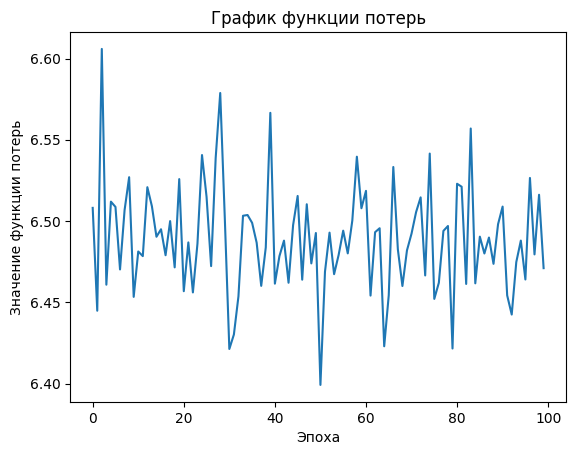

In [1232]:
plt.plot(loss_values)
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('График функции потерь')
plt.show()